# HCV redo to find  best v0 + long train rank 1

## Import & definitions

In [24]:
import os
import hashlib
import sys
from pathlib import Path
import re
import random
import time
import math
import itertools
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import randint
from scipy.stats import uniform
import scipy.stats as stats
from scipy.stats.mstats import mquantiles
import xgboost as xgb
# from helpers.ocean_helpers import save_list
'''import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2'''
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#sns.set_theme("notebook")
#mpl.style.use('seaborn-v0_8-ticks')
# definitions
DT_PAST = 5 # 5 min
PAST_HISTORY = int(6*60 / DT_PAST) #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15 : 1h15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.9 #0.8 #0.9891 # 1-(60/5*24)/50977
TARGET_NAME = "Close_ETH"
MODE_TRAIN_AE = True 
'''
#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = True # False

EPOCHS_AE = 1#30
PATIENCE_AE = 0#10
LIST_UNITS_ENC_AE = [64]
LIST_UNITS_AE = [16]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 100#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [128]
LIST_DROPOUT_PRED = [0.2]

MODE_TRAIN_LSTM = False
'''
# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = os.path.join(path_data, "pred_vals.csv")
path_save_auto_select = os.path.join(path_data, "list_auto_select.csv")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
path_save_df_feat_std = os.path.join(path_data, "df_features_05m_std.csv")
path_X_train = os.path.join(path_data, 'X_train.dat')
path_X_train_sca = os.path.join(path_data, 'X_train_sca.dat')
path_df_prob_comb = os.path.join(path_data, 'df_prob_comb.csv')
path_df_prob_comb_2 = os.path.join(path_data, 'df_prob_comb_2.csv')
path_df_prob_comb_1b = os.path.join(path_data, 'df_prob_comb_1b.csv')
path_arr_corr_matrix_targets = os.path.join(
    path_data, 'arr_corr_matrix_targets.npy'
)
path_pca = os.path.join(path_data,"pca_model.pkl")
path_hash_pca = os.path.join(path_data, 'pca_hash.txt')

'''
path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")
'''

'\npath_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")\npath_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")\npath_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")\npath_mdl_predict_autoenc_lstm  =  os.path.join(\n    path_data, "mdl_predict_autoenc_lstm")\n'

## Load 

In [25]:
# LOAD
df_prob_comb_high_event = pd.read_pickle(os.path.join(path_data, 'df_prob_comb_high_event.pkl'))
global_event_by_day = pd.read_pickle(os.path.join(path_data, 'global_event_by_day.pkl'))
df_combined_condition = pd.read_pickle(os.path.join(path_data, 'df_combined_condition.pkl'))
df_prob_comb_high_event_test = pd.read_pickle(os.path.join(path_data, 'df_prob_comb_high_event_test.pkl'))
global_event_by_day_test = pd.read_pickle(os.path.join(path_data, 'global_event_by_day_test.pkl'))
df_combined_condition_test = pd.read_pickle(os.path.join(path_data, 'df_combined_condition_test.pkl'))

df_targets = pd.read_pickle(os.path.join(path_data, "df_targets.pkl"))
df_targets_test = pd.read_pickle(os.path.join(path_data, "df_targets_test.pkl"))

with open(os.path.join(path_data, "list_df.pkl"), "rb") as f:
    list_df = pickle.load(f)

with open(os.path.join(path_data, "list_df_test.pkl"), "rb") as f:
    list_df_test = pickle.load(f)

In [26]:
# X train : df_combined_condition train
# X test: df_combined_condition_test

# Y train : high trade or not
y_comb = (list_df[0]["target_cat"] == "high")
# Y test 
y_comb_test = df_targets_test["target_cat"] == "high"

## Functions

In [27]:
# --- Define the new, simplified custom metric ---

def fun_nb_trade_fixed_window(y_true, y_pred):
    """
    Custom XGBoost metric to count 30-minute windows with at least one trade signal.
    Assumes each prediction corresponds to a 5-minute interval.
    
    Args:
        y_pred (np.ndarray): The array of predictions (0s and 1s).
        y_true (DMatrix): The DMatrix object with the true labels. We don't use it
                          for this specific metric, but it's part of the function signature.
    """
    window_size = 6  # 30 minutes / 5 minutes per data point

    # Calculate the number of full, non-overlapping windows we can form
    num_windows = len(y_pred) // window_size
    
    # If there are no full windows, the trade count is 0
    if num_windows == 0:
        return 0.0
    
    if y_pred.sum() == 0:
        return 0.0
    # Truncate y_pred to the largest size that is a multiple of window_size
    trunc_len = num_windows * window_size
    y_pred_truncated = y_pred[:trunc_len]

    # Reshape the predictions into a 2D array where each row is a 30-min window
    # The '-1' tells numpy to automatically calculate the number of rows
    pred_windows = y_pred_truncated.reshape(-1, window_size)

    # Sum the predictions in each window (each row)
    sum_in_windows = pred_windows.sum(axis=1)

    # Count how many windows have a sum of 1 or more (at least one trade signal)
    # The result of the boolean comparison is an array of True/False,
    # and .sum() counts the number of True values.
    total_trades = (sum_in_windows >= 1).sum()
    #precision_score(y_true, y_pred)
    # XGBoost custom metrics must return a list of (name, value) tuples
    return precision_score(y_true, y_pred) + 10*float(total_trades)


In [28]:
def fun_trade(total_trades, winrate, risk=250, R=1.23 ):
    return total_trades * risk * (winrate * (1 + R) - 1)

def fun_arr_trade(arr_trade, arr_winrate, risk=250, R=1.23):
    return arr_trade * risk * (arr_winrate * (1 + R) - 1)

def fun_trades_gain(y_true, y_pred):
    """
    Custom XGBoost metric to count 30-minute windows with at least one trade signal.
    Assumes each prediction corresponds to a 5-minute interval.
    
    Args:
        y_pred (np.ndarray): The array of predictions (0s and 1s).
        y_true (DMatrix): The DMatrix object with the true labels. We don't use it
                          for this specific metric, but it's part of the function signature.
    """
    risk = 250
    R = 1.23
    window_size = 6  # 30 minutes / 5 minutes per data point

    # Calculate the number of full, non-overlapping windows we can form
    num_windows = len(y_pred) // window_size
    
    # If there are no full windows, the trade count is 0
    if num_windows == 0:
        return 0.0
    if y_pred.sum() == 0:
        return 0.0
    
    # Truncate y_pred to the largest size that is a multiple of window_size
    trunc_len = num_windows * window_size
    y_pred_truncated = y_pred[:trunc_len]

    # Reshape the predictions into a 2D array where each row is a 30-min window
    # The '-1' tells numpy to automatically calculate the number of rows
    pred_windows = y_pred_truncated.reshape(-1, window_size)

    # Sum the predictions in each window (each row)
    sum_in_windows = pred_windows.sum(axis=1)

    # Count how many windows have a sum of 1 or more (at least one trade signal)
    # The result of the boolean comparison is an array of True/False,
    # and .sum() counts the number of True values.
    total_trades = (sum_in_windows >= 1).sum()
    #precision_score(y_true, y_pred)
    winrate = precision_score(y_true, y_pred)
    #total_gain = total_trades * risk * (winrate * (1 + R) - 1)
    total_gain = fun_trade(total_trades, winrate, risk, R )
    # XGBoost custom metrics must return a list of (name, value) tuples
    return total_gain #precision_score(y_true, y_pred) + 10*float(total_trades)


In [29]:
def fun_plot_trades_gain(arr_eval, arr_eval_train, title_str="XBGBoost model performance : total gain"):
    fig = make_subplots(
        rows=2, 
        cols=1, 
        shared_xaxes=True, 
        vertical_spacing=0.03
    )

    fig.add_trace(
        go.Scatter(y=arr_eval["fun_trades_gain"], name="total_gain test"),
        row=1,
        col=1,
    )
    fig.add_trace(
        go.Scatter(y=arr_eval_train["fun_trades_gain"], name="total_gain train"),
        row=1,
        col=1,
    )
    fig.update_layout(
        height=600,
        template="plotly_white",
        title=title_str,
        hovermode='x unified'
    )
    fig.update_xaxes(
        showspikes=True, 
        spikemode='across', 
        spikesnap='cursor',
        spikethickness=1,
        spikedash='dot'
    )

    # Optional: Add y-axis spikes for more context
    fig.update_yaxes(showspikes=True, spikedash='dot')

    fig.show()

In [30]:
def fun_decoded_nb_trade_fixed_window(arr_in):
    # arr_in = np.array(precision_score(y_true, y_pred) + 10*float(total_trades))
    return np.int64(arr_in/10), arr_in%10

def fun_winrate(nb_trade, gain=333, risk=250, R=1.23):
    return (gain / (nb_trade * risk)+1) /(1 + R)

def fun_arr_winrate(arr_nb_trade, gain=333, risk=250, R=1.23):
    return (gain / (arr_nb_trade * risk)+1) /(1 + R)


In [31]:
r_period_test = 1/ (y_comb_test.shape[0]/(30*288))
r_period_train = 1/ (y_comb.shape[0]/(30*288))

In [32]:
# from CV : objective="binary:hinge", scoring="precision", min_resources=500,
# Best Score (Accuracy): 0.3451
#   colsample_bytree: 0.4145
#   learning_rate: 0.5959
#   max_depth: 2
#   reg_alpha: 0.0718
#   reg_lambda: 0.6826
#   subsample: 0.4177
best_params_= {}
best_params_["colsample_bytree"] = 0.4145
best_params_["learning_rate"] = 0.5959
best_params_["max_depth"] = 2
best_params_["reg_alpha"] = 0.0718
best_params_["reg_lambda"] = 0.6826
best_params_["subsample"] = 0.4177


## XGBoost

### Search n estimators to converge

Model loaded.
Accuracy on training data: 0.757632705415604
Accuracy on test data: 0.7125504710632571
For Model XGBoost: 
precision TRAIN: 0.563
% possible trades : 2.45
nb trade per day : 7.04
precision TEST: 0.308
% possible trades : 2.03
nb trade per day : 5.85


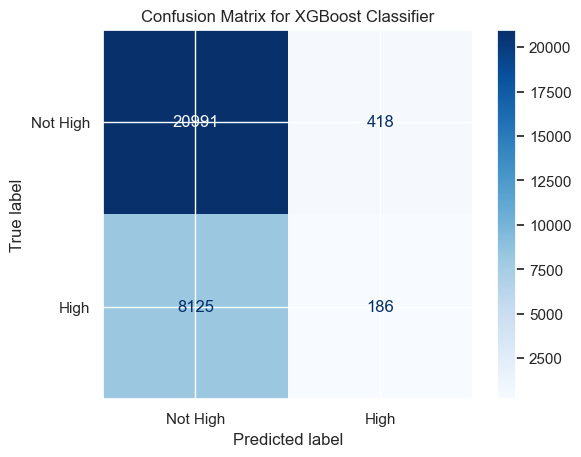

In [33]:
mode_redo_0 = False
if mode_redo_0:
    # n 100 : 14.875
    xgb_mdl = xgb.XGBClassifier(
        device='gpu', 
        verbosity=0,
        objective="binary:hinge",
        random_state=42,
        n_jobs=1,
        #use_label_encoder=False, # Recommended to avoid a future warning
        eval_metric=fun_nb_trade_fixed_window, #fun_trades_gain, #[fun_nb_trade_fixed_window, precision_score], #, # A common metric for binary classification
        max_depth=best_params_["max_depth"],
        learning_rate=best_params_["learning_rate"],
        subsample=best_params_["subsample"],
        colsample_bytree=best_params_["colsample_bytree"],
        reg_alpha=best_params_["reg_alpha"],
        reg_lambda=best_params_["reg_lambda"],
        #scale_pos_weight=1.5,  # ajuster si classes déséquilibrées
        n_estimators=3000,#400+59+1,
    )
    xgb_mdl.fit(
        df_combined_condition, 
        y_comb, 
        eval_set=[(df_combined_condition_test, y_comb_test), (df_combined_condition, y_comb)],
        verbose=0,
    )
    print("Model trained.")
    # save xgb_mdl
    with open(os.path.join(path_data,'xgb_mdl_00.pkl'), 'wb') as f:
        pickle.dump(xgb_mdl, f)
else:
    # load  xgb_mdl
    xgb_mdl = pickle.load(open(os.path.join(path_data,'xgb_mdl_00.pkl'), 'rb'))
    print("Model loaded.")

print("Accuracy on training data:", xgb_mdl.score(df_combined_condition, y_comb))
print("Accuracy on test data:", xgb_mdl.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = xgb_mdl.predict(df_combined_condition)
arr_xgb_pred = xgb_mdl.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [34]:
xgb_mdl.get_params()

{'objective': 'binary:hinge',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.4145,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': <function __main__.fun_nb_trade_fixed_window(y_true, y_pred)>,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.5959,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 2,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 15000,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': 0.0718,
 'reg_lambda': 0.6826,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.4177,
 'tree_method': None,
 'validate_parameters': None

In [35]:
arr_eval = xgb_mdl.evals_result_["validation_0"]
arr_eval_train = xgb_mdl.evals_result_["validation_1"]
arr_eval_nb_trade, arr_eval_precision = fun_decoded_nb_trade_fixed_window(np.array(arr_eval["fun_nb_trade_fixed_window"]))
arr_eval_nb_trade_train, arr_eval_precision_train = fun_decoded_nb_trade_fixed_window(
    np.array(arr_eval_train["fun_nb_trade_fixed_window"])
)
arr_eval_gain = fun_arr_trade(arr_eval_nb_trade, arr_eval_precision, risk=250, R=1.23)
arr_eval_gain_train = fun_arr_trade(arr_eval_nb_trade_train, arr_eval_precision_train, risk=250, R=1.23)

df = pd.DataFrame({
    'trades_train': arr_eval_nb_trade_train*r_period_train,
    'precision_train': arr_eval_precision_train,
    'gain_train': arr_eval_gain_train*r_period_train,
    'trades_test': arr_eval_nb_trade*r_period_test,
    'precision_test': arr_eval_precision,
    'gain_test': arr_eval_gain*r_period_test,
})
# The index is automatically available, but we can add it as a column if we want to name it.
df['run_index'] = df.index

df

trades_train  precision_train   gain_train  trades_test  \
0          0.000000         0.000000    -0.000000     0.000000   
1          0.000000         0.000000    -0.000000     0.000000   
2          0.000000         0.000000    -0.000000     0.000000   
3          0.000000         0.000000    -0.000000     0.000000   
4          0.515459         0.545455    27.881793     0.000000   
...             ...              ...          ...          ...   
14995     75.063761         0.603312  6481.488556    59.014805   
14996     64.303548         0.624079  6296.863392    50.874832   
14997     85.340731         0.582915  6398.430917    71.515478   
14998     71.101168         0.608267  6335.743477    55.235532   
14999     92.975972         0.563043  5940.836643    81.981157   

       precision_test    gain_test  run_index  
0            0.000000    -0.000000          0  
1            0.000000    -0.000000          1  
2            0.000000    -0.000000          2  
3            0.000000    -0.000000          3  
4            0.000000    -0.000000          4  
...               ...          ...        ...  
14995        0.320896 -4195.980952      14995  
14996        0.325714 -3480.573380      14996  
14997        0.318458 -5181.987563      14997  
14998        0.321053 -3922.438184      14998  
14999        0.307947 -6420.727157      14999  

[15000 rows x 7 columns]

In [36]:
df[df["gain_test"] == df["gain_test"].max()]

trades_train  precision_train  gain_train  trades_test  precision_test  \
63     15.818157         0.367604 -712.778353    22.094213        0.512048   

     gain_test  run_index  
63  783.610137         63

In [37]:
df.sort_values(by=['gain_test'], ascending=False)

trades_train  precision_train   gain_train  trades_test  \
63        15.818157         0.367604  -712.778353    22.094213   
80        11.919996         0.384937  -421.939533    19.768506   
471       20.940534         0.496933   566.235135    15.407806   
1588      33.601503         0.535254  1626.450700    20.640646   
1590      34.793503         0.526007  1504.780822    23.838493   
...             ...              ...          ...          ...   
14563     93.813593         0.562904  5987.087844    93.318977   
6672      90.205378         0.497780  2481.761940    94.772544   
14940    102.544185         0.535525  4979.052150    96.516824   
12118     92.331648         0.545069  4974.456864    95.063257   
12513     95.875431         0.534571  4604.257686   100.877524   

       precision_test    gain_test  run_index  
63           0.512048   783.610137         63  
80           0.507246   648.202296         80  
471          0.517647   594.559545        471  
1588         0.500000   593.418573       1588  
1590         0.490323   556.749723       1590  
...               ...          ...        ...  
14563        0.294618 -8002.145681      14563  
6672         0.296296 -8038.131402       6672  
14940        0.295958 -8204.259618      14940  
12118        0.292328 -8273.083382      12118  
12513        0.300874 -8298.461996      12513  

[15000 rows x 7 columns]

In [38]:
def fun_arr_winrate(arr_nb_trade, gain, risk, R):
    """Mock function to simulate win rate calculation."""
    # This is a placeholder to make the example runnable.
    # The formula is derived from a common trading gain formula.
    return (gain / arr_nb_trade + risk) / (risk * (1 + R))

# --- Updated plotting function ---

def fun_plot_pre_trade(df, gain_period_min=333, gain_period_bingo=1000):

    arr_nb_trade_winrate_train = np.linspace(max(1, min(df["trades_train"])), max(df["trades_train"]), 100)
    arr_winrate_min_train = fun_arr_winrate(arr_nb_trade_winrate_train, gain=gain_period_min, risk=250, R=1.23)
    arr_winrate_bingo_train = fun_arr_winrate(arr_nb_trade_winrate_train, gain=gain_period_bingo, risk=250, R=1.23)

    # --- Create the Plot with opacity for the test data ---
    fig = px.scatter(
        df,
        x='trades_test',
        y='precision_test',
        title="Evaluation Precision vs. Number of Trades",
        color_discrete_sequence=["#3CB620"], # Green for test data
        opacity=0.6,  # Added opacity for the main scatter plot
    )
    # Customize the hover template
    fig.update_traces(
            hovertemplate="Run Index: %{customdata[0]}<br>" +
                "Gain Train: %{customdata[1]:.2f}<br>" +
                "Trades Train: %{customdata[3]:.2f}<br>" +
                "Winrate Train: %{customdata[4]:.4f}<br>" +
                "<b>Gain Test: %{customdata[2]:.2f}</b><br>" +
                "Trades Test: %{x:.2f}<br>" +
                "Winrate Test: %{y:.4f}<br>" + # Corrected from Winrate Train
                    "<extra></extra>",
            customdata=df[['run_index', 'gain_train', "gain_test", "trades_train", "precision_train"]],
            name="test" # Assign a name for the legend
    )

    # add precision = f(nb_trade) to have a gain = 333/mth
    fig.add_scatter(
        x=arr_nb_trade_winrate_train,
        y=arr_winrate_min_train,
        mode='lines',
        line=dict(color='red', width=2),
        line_dash="dash",
        name="333$/mth Precision",
        hovertemplate=f"Gain: {gain_period_min:.2f}<br>" +
                    "Number of Trades: %{x}<br>" +
                    "Precision: %{y:.4f}<br>" +
                    "<extra></extra>",
    )
    # add precision = f(nb_trade) to have a gain = 1000/mth
    fig.add_scatter(
        x=arr_nb_trade_winrate_train,
        y=arr_winrate_bingo_train,
        mode='lines',
        line=dict(color='blue', width=2),
        line_dash="dash",
        name="1000$/mth Precision",
        hovertemplate=f"Gain: {gain_period_bingo:.2f}<br>" +
                    "Number of Trades: %{x}<br>" +
                    "Precision: %{y:.4f}<br>" +
                    "<extra></extra>",
    )
    # add train data with opacity
    fig.add_trace(
        go.Scatter(
            x=df["trades_train"],
            y=df["precision_train"],
            name="train",
            mode="markers",
            # Added marker dict to set color and opacity for the train data
            marker=dict(
                color="#FF7F0E", # Orange for train data
                opacity=0.6
            ),
            hovertemplate="Run Index: %{customdata[0]}<br>" +
                "<b>Gain Train: %{customdata[1]:.2f}</b><br>" +
                "Trades Train: %{x:.2f}<br>" +
                "Winrate Train: %{y:.4f}<br>" +
                "Gain Test: %{customdata[2]:.2f}<br>" +
                "Trades Test: %{customdata[3]:.2f}<br>" +
                "Winrate Test: %{customdata[4]:.4f}<br>" +
                    "<extra></extra>",
            customdata=df[['run_index', 'gain_train', "gain_test", "trades_test", "precision_test"]],
        )
    )

    fig.update_layout(
        xaxis_title="Number of Trades / mth",
        yaxis_title="Precision",
        font=dict(family="Arial, sans-serif", size=14),
        height=600,
        legend_title_text='Data Type' # Add a title to the legend
    )

    fig.show()

fun_plot_pre_trade(df)


In [39]:
def fun_plot_xgb_rounds(df, gain_period_min=333, gain_period_bingo=1000):
    """
    Plots XGBoost model performance with semi-transparent markers.
    """
    layout = dict(
        hoversubplots="axis",
        title=dict(text="XBGBoost model performance"),
        hovermode="x",
        grid=dict(rows=3, columns=1),
        height=600,
        xaxis_title="XGB Rounds",
        yaxis=dict(
            title="Trades"
        ),
        yaxis2=dict(
            title="Precision"
        ),
        yaxis3=dict(
            title="Gain"
        )
    )

    # Define marker styles for train and test to reduce repetition
    # The 'opacity' property (from 0 to 1) controls the alpha effect.
    train_marker = dict(color="blue", opacity=0.5)
    test_marker = dict(color="red", opacity=0.5)

    data = [
        go.Scatter(x=df["run_index"], y=df["trades_train"], xaxis="x", yaxis="y", name="trades train", mode="markers", marker=train_marker),
        go.Scatter(x=df["run_index"], y=df["trades_test"], xaxis="x", yaxis="y", name="trades test",  mode="markers", marker=test_marker),
        go.Scatter(x=df["run_index"], y=df["precision_train"], xaxis="x", yaxis="y2", name="pre train",  mode="markers", marker=train_marker),
        go.Scatter(x=df["run_index"], y=df["precision_test"], xaxis="x", yaxis="y2", name="pre test",  mode="markers", marker=test_marker),
        go.Scatter(x=df["run_index"], y=df["gain_train"], xaxis="x", yaxis="y3", name="gain train",  mode="markers", marker=train_marker),
        go.Scatter(x=df["run_index"], y=df["gain_test"], xaxis="x", yaxis="y3", name="gain test",  mode="markers", marker=test_marker),
    ]

    fig = go.Figure(data=data, layout=layout)

    fig.add_hline(
        y=gain_period_min,
        xref="x",
        yref="y3",
        line_dash="dot",
        line=dict(color='red', width=2),
        annotation_text=f"Gain: {gain_period_min:.2f}$/mth",
        annotation_position="bottom right",
        annotation_font_color="red",
        annotation_font_size=8,
        row=3,
        col=1,
    )
    fig.add_hline(
        y=gain_period_bingo,
        xref="x",
        yref="y3",
        line_dash="dot",
        annotation_text=f"Gain: {gain_period_bingo:.2f}$/mth",
        annotation_position="top right",
        annotation_font_color="blue",
        annotation_font_size=8,
        row=3,
        col=1,
    )
    fig.update_xaxes(
        showspikes=True,
        spikemode='across',
        spikesnap='cursor',
        spikethickness=1,
        spikedash='dot',
    )
    fig.show()

fun_plot_xgb_rounds(df)


In [40]:
fun_plot_xgb_rounds(df[(df["gain_test"] > -10000) & (df["run_index"] < 500)])

### CV scoring precision

In [41]:
import random
mon_generateur = random.Random(42)
nombre_1 = mon_generateur.randint(1, 100)
nombre_1

82

In [42]:
randint(1, 7).rvs(10, random_state=42)

array([4, 5, 3, 5, 5, 2, 3, 3, 3, 5])

In [43]:
uniform(0.4, 1-0.4).rvs(10, random_state=42)

array([0.62472407, 0.97042858, 0.83919637, 0.75919509, 0.49361118,
       0.49359671, 0.43485017, 0.91970569, 0.76066901, 0.82484355])

In [44]:
best_params_

{'colsample_bytree': 0.4145,
 'learning_rate': 0.5959,
 'max_depth': 2,
 'reg_alpha': 0.0718,
 'reg_lambda': 0.6826,
 'subsample': 0.4177}

In [45]:
mode_redo = True

In [46]:
# --- 3. Define the Base Model ---
# Note: 'n_estimators' is controlled by the search, so we don't set it here.
# 'early_stopping_rounds' is not used directly with HalvingRandomSearchCV.
xgb_mdl = xgb.XGBClassifier(
    objective="binary:hinge",
    random_state=42,
    #use_label_encoder=False, # Recommended to avoid a future warning
    eval_metric='logloss' # A common metric for binary classification
)

# --- 4. Define the Hyperparameter Search Space ---
param_dist = {
    'max_depth': randint(1, 4),             # Search depths from 2 to 4
    'learning_rate': uniform(0.01, 1),   # Search from 0.05 up to 0.6
    'subsample': uniform(0.2, 0.9),         # Search between 0.4 and 0.9
    'colsample_bytree': uniform(0.1, 0.7),  # Search between 0.1 and 0.6
    'reg_alpha': uniform(0.0, 1),         # Search L1 regularization
    'reg_lambda': uniform(0.0, 1),        # Search L2 regularization
    #'early_stopping_rounds': randint(20, 200),
}

tscv = TimeSeriesSplit(n_splits=5)
# --- 5. Set up and Run HalvingRandomSearchCV ---
halving_search_2 = HalvingRandomSearchCV(
    n_jobs=4,                # Use all available CPU cores
    random_state=42,
    verbose=1,                # Set to 1 or 2 to see the progress
    cv=tscv,
    factor=2,  # Keep the top 1/3 of candidates in each iteration
    estimator=xgb_mdl,
    param_distributions=param_dist,
    #max_resources=150,        # The maximum n_estimators to use for the final model
    min_resources=500,         # The initial n_estimators to start with
    scoring='precision',       # Metric for evaluation, since hinge loss gives 0/1
)

print("Starting HalvingRandomSearchCV...")
# Fit the model to the data
halving_search_2.fit(df_combined_condition, y_comb)
print("\nSearch complete!")

# --- 6. Display the Results ---
print("\n--- Cross-Validation Results ---")
print(f"Best Score (Accuracy): {halving_search_2.best_score_:.4f}")
print("\nBest Parameters Found:")
# Using a loop for cleaner printing
for param, value in halving_search_2.best_params_.items():
    if isinstance(value, float):
        print(f"  {param}: {value:.4f}")
    else:
        print(f"  {param}: {value}")

# The best_estimator_ is a fully trained model on the entire dataset
# using the best parameters found.
best_model_2 = halving_search_2.best_estimator_
print("\nBest model is now trained and ready to be used for predictions.")

Starting HalvingRandomSearchCV...
n_iterations: 10
n_required_iterations: 10
n_possible_iterations: 10
min_resources_: 500
max_resources_: 268188
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 536
n_resources: 500
Fitting 5 folds for each of 536 candidates, totalling 2680 fits


c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning:


265 fits failed out of a total of 2680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\xgboost\sklearn.py", line 1683, in fit
    self._Booster = train(


----------
iter: 1
n_candidates: 268
n_resources: 1000
Fitting 5 folds for each of 268 candidates, totalling 1340 fits


c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.1952381  0.28       0.12833333 0.06666667 0.13333333 0.24666667
 0.13615385 0.18166667 0.27714286 0.11666667 0.23333333 0.21460317
 0.15333333        nan 0.27454545 0.21904762 0.24761905 0.16969697
 0.275      0.2202381  0.29047619        nan 0.25       0.21
 0.16666667 0.31666667 0.17186813 0.18571429        nan 0.19761905
 0.18333333 0.26282051 0.25714286        nan 0.14229692 0.21111111
        nan 0.22666667 0.13333333 0.09       0.15282051 0.17666667
 0.28166667        nan 0.26333333 0.11111111 0.16666667 0.24666667
 0.25714286 0.13333333 0.10857143 0.22333333        nan 0.33186813
 0.18333333 0.0952381  0.2        0.08484848 0.25571429 0.06666667
 0.19666667 0.27714286        nan 0.13653846        nan 0.14666667
 0.18666667 0.13015873 0.185      0.2        0.21333333 0.21333333
        nan 0.24833333        nan 0.14       

----------
iter: 2
n_candidates: 134
n_resources: 2000
Fitting 5 folds for each of 134 candidates, totalling 670 fits


c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.1952381  0.28       0.12833333 0.06666667 0.13333333 0.24666667
 0.13615385 0.18166667 0.27714286 0.11666667 0.23333333 0.21460317
 0.15333333        nan 0.27454545 0.21904762 0.24761905 0.16969697
 0.275      0.2202381  0.29047619        nan 0.25       0.21
 0.16666667 0.31666667 0.17186813 0.18571429        nan 0.19761905
 0.18333333 0.26282051 0.25714286        nan 0.14229692 0.21111111
        nan 0.22666667 0.13333333 0.09       0.15282051 0.17666667
 0.28166667        nan 0.26333333 0.11111111 0.16666667 0.24666667
 0.25714286 0.13333333 0.10857143 0.22333333        nan 0.33186813
 0.18333333 0.0952381  0.2        0.08484848 0.25571429 0.06666667
 0.19666667 0.27714286        nan 0.13653846        nan 0.14666667
 0.18666667 0.13015873 0.185      0.2        0.21333333 0.21333333
        nan 0.24833333        nan 0.14       

----------
iter: 3
n_candidates: 67
n_resources: 4000
Fitting 5 folds for each of 67 candidates, totalling 335 fits


c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.1952381  0.28       0.12833333 ... 0.21111111 0.38939394 0.125     ]

c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [1.         0.9125     1.         ... 0.93333333 0.75135393 0.375     ]



----------
iter: 4
n_candidates: 34
n_resources: 8000
Fitting 5 folds for each of 34 candidates, totalling 170 fits


c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.1952381  0.28       0.12833333 ... 0.32334123 0.10681818 0.16666667]

c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [1.         0.9125     1.         ... 0.8742906  0.93142857 0.53333333]



----------
iter: 5
n_candidates: 17
n_resources: 16000
Fitting 5 folds for each of 17 candidates, totalling 85 fits


c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.1952381  0.28       0.12833333 ... 0.34561171 0.15058824 0.29247376]

c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [1.         0.9125     1.         ... 0.76804023 0.67326859 0.79186204]



----------
iter: 6
n_candidates: 9
n_resources: 32000
Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.1952381  0.28       0.12833333 ... 0.37195809 0.30975229 0.37049467]

c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [1.         0.9125     1.         ... 0.85716925 0.75887215 0.5984051 ]



----------
iter: 7
n_candidates: 5
n_resources: 64000
Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.1952381  0.28       0.12833333 ... 0.34726432 0.36812493 0.2420379 ]

c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [1.         0.9125     1.         ... 0.57374023 0.86002358 0.7496898 ]



----------
iter: 8
n_candidates: 3
n_resources: 128000
Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.1952381  0.28       0.12833333 ... 0.30272052 0.32690282 0.25147347]

c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [1.         0.9125     1.         ... 0.58152099 0.68832356 0.87036732]



----------
iter: 9
n_candidates: 2
n_resources: 256000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.1952381  0.28       0.12833333 ... 0.25147347 0.34272462 0.33771633]

c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [1.         0.9125     1.         ... 0.87036732 0.51479622 0.68208848]




Search complete!

--- Cross-Validation Results ---
Best Score (Accuracy): 0.3427

Best Parameters Found:
  colsample_bytree: 0.1620
  learning_rate: 0.4976
  max_depth: 2
  reg_alpha: 0.2803
  reg_lambda: 0.6874
  subsample: 0.2220


NameError: name 'halving_search' is not defined

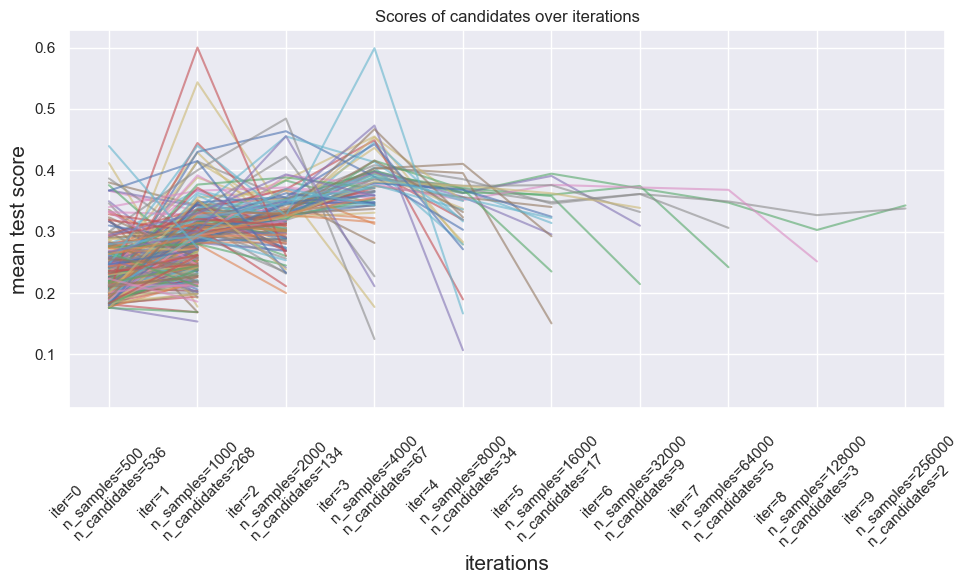

In [56]:
results = pd.DataFrame(halving_search_2.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={halving_search_2.n_resources_[i]}\nn_candidates={halving_search_2.n_candidates_[i]}"
    for i in range(halving_search_2.n_iterations_)
]

ax.set_xticks(range(halving_search_2.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.gcf().set_size_inches((10, 6))
plt.tight_layout()
plt.show()

In [57]:
mean_scores

params_str  {'colsample_bytree': np.float64(0.10016626650311922), 'learning_rate': np.float64(0.19547290957672248), 'max_depth': 2, 'reg_alpha': np.float64(0.9390676985128962), 'reg_lambda': np.float64(0.7987832357736654), 'subsample': np.float64(1.0981406994800038)}  \
iter                                                                                                                                                                                                                                                                          
0                                                         NaN                                                                                                                                                                                                                 
1                                                         NaN                                                                                                                                                                                                                 
2                                                         NaN                                                                                                                                                                                                                 
3                                                         NaN                                                                                                                                                                                                                 
4                                                         NaN                                                                                                                                                                                                                 
5                                                         NaN                                                                                                                                                                                                                 
6                                                         NaN                                                                                                                                                                                                                 
7                                                         NaN                                                                                                                                                                                                                 
8                                                         NaN                                                                                                                                                                                                                 
9                                                         NaN                                                                                                                                                                                                                 

params_str  {'colsample_bytree': np.float64(0.101031675460418), 'learning_rate': np.float64(0.7393447940879964), 'max_depth': 2, 'reg_alpha': np.float64(0.7317247365642129), 'reg_lambda': np.float64(0.6406355928025865), 'subsample': np.float64(0.5743495141236696)}  \
iter                                                                                                                                                                                                                                                                       
0                                                    0.145714                                                                                                                                                      

In [58]:
results

iter  n_resources  mean_fit_time  std_fit_time  mean_score_time  \
0        0          500       2.885427      0.190944         0.606706   
1        0          500       2.673753      0.225942         0.695277   
2        0          500       2.637391      0.198533         0.611858   
3        0          500       2.549850      0.271236         0.619844   
4        0          500       2.535507      0.239723         0.631032   
...    ...          ...            ...           ...              ...   
1070     8       128000      30.697181     12.740366         2.210991   
1071     8       128000      33.542828     11.933451         2.343251   
1072     8       128000      28.555397      8.200015         1.855386   
1073     9       256000      58.146391     25.367729         3.241631   
1074     9       256000      52.031940     15.584261         2.392109   

      std_score_time  param_colsample_bytree  param_learning_rate  \
0           0.052923                0.362178             0.960714   
1           0.131488                0.169982             0.469249   
2           0.072759                0.778937             0.842443   
3           0.099206                0.528157             0.017066   
4           0.122806                0.304501             0.376362   
...              ...                     ...                  ...   
1070        0.171401                0.162023             0.497628   
1071        0.212426                0.211501             0.614954   
1072        0.611053                0.506327             0.149197   
1073        0.382651                0.162023             0.497628   
1074        0.801674                0.211501             0.614954   

      param_max_depth  param_reg_alpha  ...  std_test_score  rank_test_score  \
0                   3         0.779691  ...        0.126348              736   
1                   1         0.601115  ...        0.177138              403   
2                   2         0.000779  ...        0.160866              951   
3                   1         0.291229  ...        0.133333             1018   
4                   2         0.090606  ...        0.163299              925   
...               ...              ...  ...             ...              ...   
1070                2         0.280334  ...        0.025387              318   
1071                3         0.977174  ...        0.013598              225   
1072                3         0.150521  ...        0.151285              518   
1073                2         0.280334  ...        0.025431              165   
1074                3         0.977174  ...        0.021322              175   

     split0_train_score  split1_train_score  split2_train_score  \
0              1.000000            1.000000            1.000000   
1              1.000000            1.000000            0.875000   
2              1.000000            1.000000            1.000000   
3              0.000000            0.000000            0.666667   
4              1.000000            1.000000            1.000000   
...                 ...                 ...                 ...   
1070           0.663551            0.561644            0.563549   
1071           0.783646            0.796687            0.698317   
1072           0.772575            0.815625            0.909091   
1073           0.588643            0.562430            0.468330   
1074           0.799722            0.773364            0.711196   

      split3_train_score  split4_train_score  mean_train_score  \
0               1.000000            1.000000          1.000000   
1               0.875000            0.812500          0.912500   
2               1.000000            1.000000          1.000000   
3               1.000000            0.285714          0.390476   
4               1.000000            1.000000          1.000000   
...                  ...                 ...               ...   
1070            0.622407            0.496454          0.581521   
1071  

In [59]:
results.filter(items=["param_colsample_bytree", "param_learning_rate", "param_max_depth", 
                      "param_reg_alpha", "param_reg_lambda", "param_subsample", 
                      "n_resources", "mean_test_score","mean_train_score",'rank_test_score']).sort_values(by="mean_test_score", ascending=False)

param_colsample_bytree  param_learning_rate  param_max_depth  \
605                0.640317             0.022203                3   
947                0.767861             0.145001                1   
543                0.499455             0.578093                1   
928                0.576159             0.051673                1   
979                0.594961             0.060226                2   
..                      ...                  ...              ...   
454                0.704381             0.411306                3   
463                0.495489             0.876548                2   
467                0.173755             0.791824                1   
507                0.328437             0.849660                1   
526                0.369049             0.035193                3   

     param_reg_alpha  param_reg_lambda  param_subsample  n_resources  \
605         0.693948          0.542724         0.426619         1000   
947         0.269911          0.539843         0.345812         4000   
543         0.646459          0.974194         0.962355         1000   
928         0.746207          0.659036         0.921918         2000   
979         0.710110          0.666854         0.390001         4000   
..               ...               ...              ...          ...   
454         0.929228          0.405103         1.015500          500   
463         0.891872          0.433817         1.018949          500   
467         0.048186          0.360050         1.061120          500   
507         0.353050          0.894094         1.051811          500   
526         0.011418          0.703700         1.073231          500   

     mean_test_score  mean_train_score  rank_test_score  
605         0.600000          0.975000                1  
947         0.598889          0.891126                2  
543         0.543333          0.988889                3  
928         0.484242          0.918095                4  
979         0.472857          0.949524                5  
..               ...               ...              ...  
454              NaN               NaN             1023  
463              NaN               NaN             1023  
467              NaN               NaN             1023  
507              NaN               NaN             1023  
526              NaN               NaN             1023  

[1075 rows x 10 columns]

Model trained.
Accuracy on training data: 0.7537510999746446
Accuracy on test data: 0.7186069986541049
For Model XGBoost: 
precision TRAIN: 0.386
% possible trades : 0.35
nb trade per day : 1.01
precision TEST: 0.297
% possible trades : 0.43
nb trade per day : 1.24


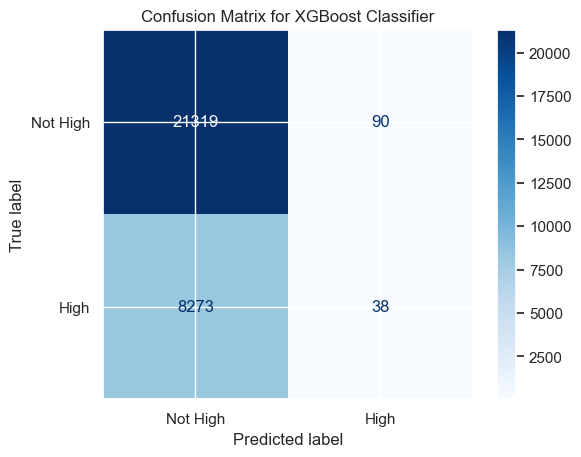

In [60]:
print("Model trained.")
print("Accuracy on training data:", best_model_2.score(df_combined_condition, y_comb))
print("Accuracy on test data:", best_model_2.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = best_model_2.predict(df_combined_condition)
arr_xgb_pred = best_model_2.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [61]:
halving_search_2.best_params_

{'colsample_bytree': np.float64(0.16202329977877533),
 'learning_rate': np.float64(0.4976278096672109),
 'max_depth': 2,
 'reg_alpha': np.float64(0.2803344607915209),
 'reg_lambda': np.float64(0.6874063641362376),
 'subsample': np.float64(0.22204860344088712)}

In [62]:
halving_search_2.best_index_

np.int64(1073)

In [63]:
results.iloc[halving_search_2.best_index_]

iter                                                                      9
n_resources                                                          256000
mean_fit_time                                                     58.146391
std_fit_time                                                      25.367729
mean_score_time                                                    3.241631
std_score_time                                                     0.382651
param_colsample_bytree                                             0.162023
param_learning_rate                                                0.497628
param_max_depth                                                           2
param_reg_alpha                                                    0.280334
param_reg_lambda                                                   0.687406
param_subsample                                                    0.222049
params                    {'colsample_bytree': 0.16202329977877533, 'lea...
split0_test_

In [64]:
results.columns

Index(['iter', 'n_resources', 'mean_fit_time', 'std_fit_time',
       'mean_score_time', 'std_score_time', 'param_colsample_bytree',
       'param_learning_rate', 'param_max_depth', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score', 'params_str'],
      dtype='object')

In [66]:
results[results["rank_test_score"] == 1].iloc[0]["param_learning_rate"]

np.float64(0.02220307231804452)

In [83]:
results.filter(items=['param_learning_rate', 'param_max_depth', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample', "param_colsample_bytree",
       'param_n_estimators',  'split0_test_score', 'split1_test_score', 'split2_test_score',"n_resources",'mean_test_score', "mean_train_score", "rank_test_score"]
).sort_values(by="mean_test_score", ascending=False).head(20)

param_learning_rate  param_max_depth  param_reg_alpha  param_reg_lambda  \
605             0.022203                3         0.693948          0.542724   
947             0.145001                1         0.269911          0.539843   
543             0.578093                1         0.646459          0.974194   
928             0.051673                1         0.746207          0.659036   
979             0.060226                2         0.710110          0.666854   
955             0.163807                3         0.919531          0.993255   
933             0.183294                1         0.442352          0.239787   
843             0.014940                2         0.323131          0.973098   
903             0.289979                1         0.187044          0.323679   
996             0.351248                1         0.398823          0.580172   
954             0.578093                1         0.646459          0.974194   
991             0.207154                1         0.351623          0.101421   
941             0.386463                1         0.480370          0.985286   
592             0.205833                2         0.896075          0.847194   
987             0.045422                3         0.655242          0.550857   
720             0.145001                1         0.269911          0.539843   
319             0.952315                3         0.185196          0.174109   
970             0.580444                1         0.961172          0.844534   
606             0.183294                1         0.442352          0.239787   
702             0.668885                1         0.666972          0.577185   

     param_subsample  param_colsample_bytree  split0_test_score  \
605         0.426619                0.640317           1.000000   
947         0.345812                0.767861           0.777778   
543         0.962355                0.499455           1.000000   
928         0.921918                0.576159           0.800000   
979         0.390001                0.594961           0.714286   
955         0.240420                0.730968           0.555556   
933         0.284486                0.386267           0.545455   
843         0.722101                0.775583           0.833333   
903         0.582893                0.500129           0.555556   
996         0.680242                0.117949           0.523810   
954         0.962355                0.499455           0.500000   
991         0.637285                0.366052           0.500000   
941         0.539065                0.118457           0.500000   
592         0.483632                0.257767           0.666667   
987         0.278288                0.696535           0.545455   
720         0.345812                0.767861           0.200000   
319         0.288556                0.779525           0.500000   
970         0.872588                0.328579           0.516129   
606         0.284486                0.386267           0.250000   
702         0.513716                0.250973           0.333333   

     split1_test_score  split2_test_score  n_resources  mean_test_score  \
605           0.000000           0.666667         1000         0.600000   
947           0.300000           0.250000         4000         0.598889   
543           0.400000           0.600000         1000         0.543333   
928           0.454545           0.666667         2000         0.484242   
979           0.250000           0.400000         4000         0.472857   
955           0.437500           0.666667         4000         0.466944   
933           0.272727           0.600000         2000         0.463636   
843           0.500000           0.444444         2000         0.455556   
903           0.461538           0.571429         2000         0.455205   
996           0.318182           0.400000         4000         0.455065   
954           0.454545           0.428571         4000         0.453680   
991           0.

In [85]:
results[results["n_resources"]>250000].filter(items=['param_learning_rate', 'param_max_depth', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample', "param_colsample_bytree",
       'param_n_estimators',  'split0_test_score', 'split1_test_score', 'split2_test_score',"n_resources",'mean_test_score', "mean_train_score", "rank_test_score"]
).sort_values(by="mean_test_score", ascending=False).head(20)

param_learning_rate  param_max_depth  param_reg_alpha  param_reg_lambda  \
1073             0.497628                2         0.280334          0.687406   
1074             0.614954                3         0.977174          0.406908   

      param_subsample  param_colsample_bytree  split0_test_score  \
1073         0.222049                0.162023           0.333333   
1074         0.983678                0.211501           0.364286   

      split1_test_score  split2_test_score  n_resources  mean_test_score  \
1073           0.320847           0.361582       256000         0.342725   
1074           0.311475           0.313725       256000         0.337716   

      mean_train_score  rank_test_score  
1073          0.514796              165  
1074          0.682088              175

### Long train : rank 11 (1 , 5, 18  nok)

In [74]:
best_model_2.get_xgb_params()

{'objective': 'binary:hinge',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': np.float64(0.16202329977877533),
 'device': None,
 'eval_metric': 'logloss',
 'gamma': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': np.float64(0.4976278096672109),
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 2,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': np.float64(0.2803344607915209),
 'reg_lambda': np.float64(0.6874063641362376),
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': np.float64(0.22204860344088712),
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [71]:
results.iloc[halving_search_2.best_index_]["rank_test_score"]

np.int32(165)

In [73]:
rank_best = results.iloc[halving_search_2.best_index_]["rank_test_score"] 
params_ = {
    'colsample_bytree': results[results["rank_test_score"] == rank_best].iloc[0]["param_colsample_bytree"],
    'learning_rate': results[results["rank_test_score"] == rank_best].iloc[0]["param_learning_rate"],
    'max_depth': results[results["rank_test_score"] == rank_best].iloc[0]["param_max_depth"],
    'reg_alpha': results[results["rank_test_score"] == rank_best].iloc[0]["param_reg_alpha"],
    'reg_lambda': results[results["rank_test_score"] == rank_best].iloc[0]["param_reg_lambda"],
    'subsample': results[results["rank_test_score"] == rank_best].iloc[0]["param_subsample"],
}
params_

{'colsample_bytree': np.float64(0.16202329977877533),
 'learning_rate': np.float64(0.4976278096672109),
 'max_depth': np.int64(2),
 'reg_alpha': np.float64(0.2803344607915209),
 'reg_lambda': np.float64(0.6874063641362376),
 'subsample': np.float64(0.22204860344088712)}

[0]	validation_0-error:0.27964	validation_0-fun_nb_trade_fixed_window:0.00000	validation_1-error:0.24545	validation_1-fun_nb_trade_fixed_window:0.00000
[100]	validation_0-error:0.28025	validation_0-fun_nb_trade_fixed_window:230.25000	validation_1-error:0.24570	validation_1-fun_nb_trade_fixed_window:2400.42056
[200]	validation_0-error:0.28136	validation_0-fun_nb_trade_fixed_window:810.33333	validation_1-error:0.24679	validation_1-fun_nb_trade_fixed_window:7330.37096
[300]	validation_0-error:0.28038	validation_0-fun_nb_trade_fixed_window:390.29630	validation_1-error:0.24572	validation_1-fun_nb_trade_fixed_window:5610.46790
[400]	validation_0-error:0.28022	validation_0-fun_nb_trade_fixed_window:330.31111	validation_1-error:0.24585	validation_1-fun_nb_trade_fixed_window:5450.45493
[500]	validation_0-error:0.28119	validation_0-fun_nb_trade_fixed_window:690.29464	validation_1-error:0.24595	validation_1-fun_nb_trade_fixed_window:9500.46874
[600]	validation_0-error:0.28096	validation_0-fun_nb_

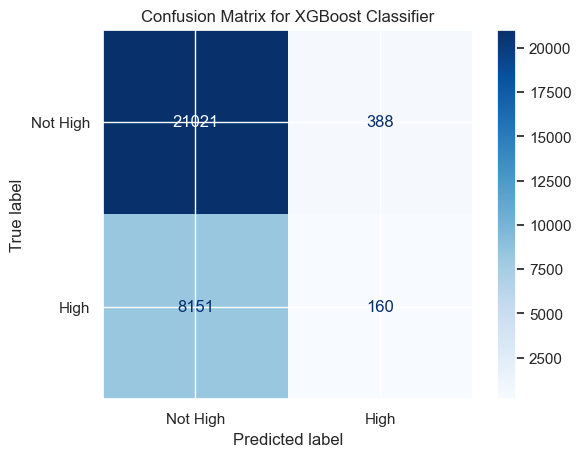

In [75]:
mode_redo = True

if mode_redo:
    # n 100 : 14.875
    xgb_mdl_long = xgb.XGBClassifier(
        device='cuda',
        verbosity=0,
        objective="binary:hinge",
        random_state=42,
        n_jobs=-1,
        #use_label_encoder=False, # Recommended to avoid a future warning
        eval_metric=fun_nb_trade_fixed_window, #fun_trades_gain, #[fun_nb_trade_fixed_window, precision_score], #, # A common metric for binary classification
        max_depth=params_['max_depth'],
        learning_rate=params_['learning_rate'],
        subsample=params_['subsample'],
        colsample_bytree=params_['colsample_bytree'],
        reg_alpha=params_['reg_alpha'],
        reg_lambda=params_['reg_lambda'],
        #scale_pos_weight=1.5,  # ajuster si classes déséquilibrées
        n_estimators=10000,#400+59+1,
    )
    xgb_mdl_long.fit(
        df_combined_condition, 
        y_comb, 
        eval_set=[(df_combined_condition_test, y_comb_test), (df_combined_condition, y_comb)],
        verbose=100,
    )
    print("Model trained.")
    # save xgb_mdl_long
    with open(os.path.join(path_data,'xgb_mdl_11_01.pkl'), 'wb') as f:
        pickle.dump(xgb_mdl_long, f)
else:
    # load  xgb_mdl
    xgb_mdl_long = pickle.load(open(os.path.join(path_data,'xgb_mdl_11_01.pkl'), 'rb'))
    print("Model loaded.")

print("Accuracy on training data:", xgb_mdl_long.score(df_combined_condition, y_comb))
print("Accuracy on test data:", xgb_mdl_long.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = xgb_mdl_long.predict(df_combined_condition)
arr_xgb_pred = xgb_mdl_long.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [76]:
xgb_mdl_long.get_xgb_params()

{'objective': 'binary:hinge',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': np.float64(0.16202329977877533),
 'device': 'cuda',
 'gamma': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': np.float64(0.4976278096672109),
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': np.int64(2),
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': np.float64(0.2803344607915209),
 'reg_lambda': np.float64(0.6874063641362376),
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': np.float64(0.22204860344088712),
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': 0}

In [77]:
new_params_= {}
new_params_["colsample_bytree"] = xgb_mdl_long.get_xgb_params()["colsample_bytree"]
new_params_["learning_rate"] = xgb_mdl_long.get_xgb_params()["learning_rate"]
new_params_["max_depth"] = xgb_mdl_long.get_xgb_params()["max_depth"]
new_params_["reg_alpha"] = xgb_mdl_long.get_xgb_params()["reg_alpha"]
new_params_["reg_lambda"] = xgb_mdl_long.get_xgb_params()["reg_lambda"]
new_params_["subsample"] = xgb_mdl_long.get_xgb_params()["subsample"]
new_params_

{'colsample_bytree': np.float64(0.16202329977877533),
 'learning_rate': np.float64(0.4976278096672109),
 'max_depth': np.int64(2),
 'reg_alpha': np.float64(0.2803344607915209),
 'reg_lambda': np.float64(0.6874063641362376),
 'subsample': np.float64(0.22204860344088712)}

In [78]:
# create dataframe to compare best_prams_ and new_params_
df_params_compare = pd.DataFrame({
    'best_params_': pd.Series(best_params_),
    'new_params_': pd.Series(new_params_)
})  
df_params_compare

best_params_  new_params_
colsample_bytree        0.4145     0.162023
learning_rate           0.5959     0.497628
max_depth               2.0000     2.000000
reg_alpha               0.0718     0.280334
reg_lambda              0.6826     0.687406
subsample               0.4177     0.222049

In [79]:
arr_eval = xgb_mdl_long.evals_result_["validation_0"]
arr_eval_train = xgb_mdl_long.evals_result_["validation_1"]
arr_eval_nb_trade, arr_eval_precision = fun_decoded_nb_trade_fixed_window(np.array(arr_eval["fun_nb_trade_fixed_window"]))
arr_eval_nb_trade_train, arr_eval_precision_train = fun_decoded_nb_trade_fixed_window(
    np.array(arr_eval_train["fun_nb_trade_fixed_window"])
)
arr_eval_gain = fun_arr_trade(arr_eval_nb_trade, arr_eval_precision, risk=250, R=1.23)
arr_eval_gain_train = fun_arr_trade(arr_eval_nb_trade_train, arr_eval_precision_train, risk=250, R=1.23)

df = pd.DataFrame({
    'trades_train': arr_eval_nb_trade_train*r_period_train,
    'precision_train': arr_eval_precision_train,
    'gain_train': arr_eval_gain_train*r_period_train,
    'trades_test': arr_eval_nb_trade*r_period_test,
    'precision_test': arr_eval_precision,
    'gain_test': arr_eval_gain*r_period_test,
})
# The index is automatically available, but we can add it as a column if we want to name it.
df['run_index'] = df.index

df

trades_train  precision_train   gain_train  trades_test  precision_test  \
0         0.000000         0.000000    -0.000000     0.000000        0.000000   
1         0.000000         0.000000    -0.000000     0.000000        0.000000   
2         0.000000         0.000000    -0.000000     0.000000        0.000000   
3         0.000000         0.000000    -0.000000     0.000000        0.000000   
4         0.000000         0.000000    -0.000000     0.000000        0.000000   
...            ...              ...          ...          ...             ...   
9995     71.487762         0.560816  4479.060029    60.759085        0.283688   
9996     90.785270         0.525566  3904.043053    83.144011        0.301613   
9997     75.514788         0.557651  4598.128110    68.317631        0.280738   
9998     65.656629         0.570628  4472.865068    55.235532        0.280788   
9999     83.601056         0.539663  4252.127150    74.131898        0.291971   

        gain_test  run_index  
0       -0.000000          0  
1       -0.000000          1  
2       -0.000000          2  
3       -0.000000          3  
4       -0.000000          4  
...           ...        ...  
9995 -5580.353738       9995  
9996 -6805.399847       9996  
9997 -6386.917307       9997  
9998 -5162.350899       9998  
9999 -6466.241327       9999  

[10000 rows x 7 columns]

In [80]:
fun_plot_pre_trade(df)

In [81]:
fun_plot_xgb_rounds(df)

In [82]:
xgb_mdl_long.get_params()

{'objective': 'binary:hinge',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': np.float64(0.16202329977877533),
 'device': 'cuda',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': <function __main__.fun_nb_trade_fixed_window(y_true, y_pred)>,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': np.float64(0.4976278096672109),
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': np.int64(2),
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 10000,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': np.float64(0.2803344607915209),
 'reg_lambda': np.float64(0.6874063641362376),
 'sampling_metho